In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax

import seaborn as sns

import statsmodels.api as sm

from plotly.offline import init_notebook_mode, iplot, plot

import statsmodels.formula.api as smf
import graphviz as gr

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
data = pd.read_csv('/kaggle/input/grallrounds/Grants Results History Round over Round  Grant over Grant - GR1-GR12.csv')

def extract_values(df):
    df.total = df.total.apply(lambda x: str(x).replace(',', '').replace('$', '')).astype(float)
    df.crowdfund_amount_contributions_usd = df.crowdfund_amount_contributions_usd.apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float)
    df.match_amount = df.match_amount.apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float)
    return df



def cleaned_data(d):
    d = d[d.total.notnull()]

    d.region = d.region.fillna('undefined')
    d.crowdfund_amount_contributions_usd = d.crowdfund_amount_contributions_usd.fillna(0)

    abc = d.groupby(['grant_id']).agg(grant_uniq=("grant_title", "nunique"), mode=("grant_title", lambda x:x.value_counts().index[0]))

    for x in abc[abc['grant_uniq']==2].index:
        d.loc[lambda df: df['grant_id'] == x, 'grant_title'] = abc.loc[x, 'mode']
        
    return d.reset_index(drop=True)

data = extract_values(data)
data = cleaned_data(data)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [3]:
data = pd.get_dummies(data, columns= ['region','category'])

In [4]:
corr = data.corr('spearman')
corr

,round_number,grant_id,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total,region_africa,region_east_asia,region_europe,region_india,region_latin_america,region_middle_east,region_none,region_north_america,region_oceania,region_southeast_asia,region_undefined,category_APOLLO,category_Building Gitcoin,category_Community,category_Crypto for Black Lives,category_Grants Round 12,category_Health,category_Infra Tech,category_Matic: Build-n-Earn,category_NFTs,category_dApp Tech,category_dGov
round_number,1.000000,0.617750,-0.247293,0.190134,0.226799,0.068155,0.007326,0.081714,0.091655,0.152134,0.060562,0.080723,0.027897,-0.429258,0.182245,0.001371,0.057850,-0.027696,-0.020104,0.007586,0.000703,-0.045510,0.194168,-0.127264,-0.110885,-0.011605,0.186211,-0.063671,0.074931
grant_id,0.617750,1.000000,-0.199791,0.129002,0.143110,0.012231,-0.030999,0.094876,0.141522,0.196943,0.102263,0.087765,0.008117,-0.492201,0.253313,-0.004248,0.106578,-0.150776,-0.000276,0.047182,0.026116,-0.011478,0.229411,-0.074163,-0.272961,-0.001515,0.289668,-0.054506,0.091036
match_amount,-0.247293,-0.199791,1.000000,0.791422,0.779800,0.855246,0.906071,-0.003754,0.009878,-0.012089,-0.050350,0.027351,-0.042783,-0.077323,-0.019608,0.018785,-0.035176,0.161300,0.006398,0.086211,-0.010001,0.036739,0.035482,0.091721,0.123461,0.009607,-0.071797,-0.104169,0.040605
num_contributions,0.190134,0.129002,0.791422,1.000000,0.980474,0.903513,0.885986,0.008723,0.062223,0.091614,0.002486,0.063125,-0.005979,-0.356678,0.100695,0.018002,0.016947,0.152112,-0.014524,0.086633,-0.064697,0.002834,0.055725,-0.029654,0.060218,0.001976,0.088538,-0.072957,0.061298
num_unique_contributors,0.226799,0.143110,0.779800,0.980474,1.000000,0.888497,0.872802,0.011650,0.058287,0.094709,0.003370,0.064065,-0.006408,-0.355976,0.103210,0.014479,0.014708,0.147526,-0.012052,0.089942,-0.071379,0.005570,0.064656,-0.026707,0.062596,0.002603,0.103610,-0.081964,0.065982
crowdfund_amount_contributions_usd,0.068155,0.012231,0.855246,0.903513,0.888497,1.000000,0.982053,-0.002153,0.026482,0.059430,-0.020597,0.045602,-0.021640,-0.265908,0.064695,0.022219,-0.001032,0.172938,-0.006846,0.081484,-0.028073,0.024720,0.065685,0.008778,0.107810,0.001431,0.014149,-0.110421,0.036300
total,0.007326,-0.030999,0.906071,0.885986,0.872802,0.982053,1.000000,0.003512,0.020568,0.044854,-0.026812,0.040651,-0.029025,-0.228920,0.050006,0.022032,-0.008435,0.170627,-0.006854,0.083508,-0.027162,0.025935,0.060606,0.055662,0.106350,0.002532,0.001023,-0.111361,0.037249
region_africa,0.081714,0.094876,-0.003754,0.008723,0.011650,-0.002153,0.003512,1.000000,-0.041545,-0.072586,-0.024234,-0.036522,-0.021248,-0.101754,-0.080833,-0.017040,-0.023549,-0.064454,-0.003959,0.021270,0.014678,-0.006468,-0.021751,-0.015398,-0.056640,-0.002285,0.042748,0.015635,-0.011376
region_east_asia,0.091655,0.141522,0.009878,0.062223,0.058287,0.026482,0.020568,-0.041545,1.000000,-0.116077,-0.038754,-0.058404,-0.033980,-0.162721,-0.129266,-0.027250,-0.037659,-0.103072,-0.006331,-0.008812,0.066933,-0.010343,-0.003417,-0.024623,-0.027409,-0.003654,-0.010919,-0.037280,0.023772
region_europe,0.152134,0.196943,-0.012089,0.091614,0.094709,0.059430,0.044854,-0.072586,-0.116077,1.000000,-0.067709,-0.102041,-0.059368,-0.284298,-0.225847,-0.047609,-0.065796,-0.180083,-0.011061,-0.034480,-0.035277,-0.018071,0.052623,-0.043021,-0.025103,-0.006385,0.088594,0.009445,-0.009659


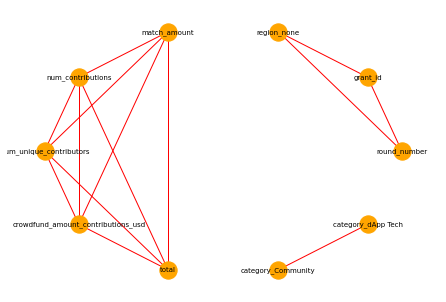

In [5]:
import networkx as nx

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# correlation
threshold = 0.4

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) >= threshold ) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network
nx.draw_circular(G, with_labels=True, node_color='orange', node_size=300, edge_color='red', linewidths=1, font_size=7)

http://man.hubwiz.com/docset/Seaborn.docset/Contents/Resources/Documents/generated/seaborn.clustermap.html

https://seaborn.pydata.org/examples/structured_heatmap.html

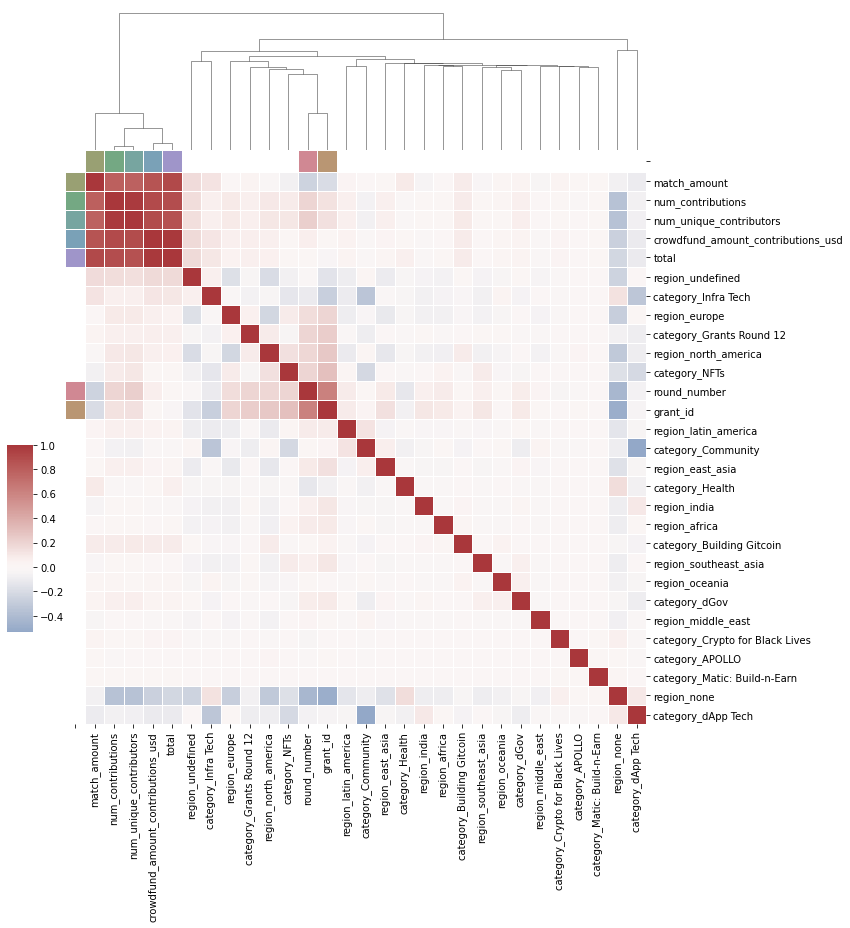

In [6]:
# Create a categorical palette to identify the networks
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
used_columns = data.select_dtypes(include=numerics)
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_columns), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = data.columns.get_level_values(0)
network_colors = pd.Series(networks, index=data.columns).map(network_lut)

# Draw the full plot
g = sns.clustermap(data.corr('spearman'), center=0, cmap="vlag",
                   row_colors=network_colors, col_colors=network_colors,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))

g.ax_row_dendrogram.remove()
plt.savefig('MSNObar.png', format='png')

In [7]:
# prepare data frames
gr12 = data[data.round_number==12]
gr11 = data[data.round_number==11]
gr10 = data[data.round_number==10]

# import graph objects as "go"
import plotly.graph_objs as go
# creating trace1
trace1 =go.Scatter(
                    x = gr12.total,
                    y = gr12.num_unique_contributors,
                    mode = "markers",
                    name = "12",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= gr12.grant_id)


# creating trace2
trace2 =go.Scatter(
                    x = gr11.total,
                    y = gr11.num_unique_contributors,
                    mode = "markers",
                    name = "11",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= gr11.grant_id)
# creating trace3
trace3 =go.Scatter(
                    x = gr10.total,
                    y = gr10.num_unique_contributors,
                    mode = "markers",
                    name = "10",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= gr10.grant_id)

dat = [trace1, trace2, trace3]

layout = dict(title = '10, 11 and 12 rounds',
              xaxis= dict(title= 'Total raised funding',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Number of Unique Contributors',ticklen= 5,zeroline= False)
             )
fig = dict(data = dat, layout = layout)
iplot(fig)

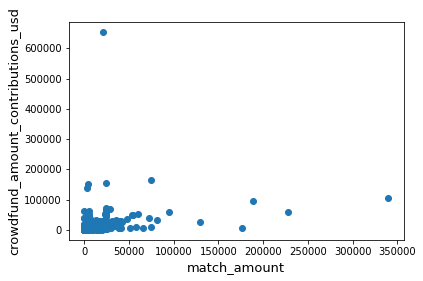

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = data['match_amount'], y = data['crowdfund_amount_contributions_usd'])
plt.ylabel('crowdfund_amount_contributions_usd', fontsize=13)
plt.xlabel('match_amount', fontsize=13)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



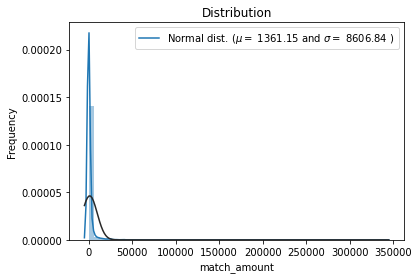

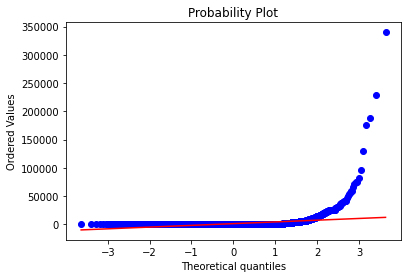

In [9]:
def plot_dist(var):
    sns.distplot(var, fit=norm);
    (mu, sigma) = norm.fit(var)

    #plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution')

    #QQ-plot
    plt.figure()
    stats.probplot(var, plot=plt)
    plt.show()

plot_dist(data['match_amount'])

In [10]:
df = data[data.round_number.isin([8, 9, 10, 11])].grant_id.value_counts()
d = data[(data.grant_id.isin(df[df==4].index))]
d

,round_number,round_start_date,round_end_date,grant_title,grant_id,url,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total,region_africa,region_east_asia,region_europe,region_india,region_latin_america,region_middle_east,region_none,region_north_america,region_oceania,region_southeast_asia,region_undefined,category_APOLLO,category_Building Gitcoin,category_Community,category_Crypto for Black Lives,category_Grants Round 12,category_Health,category_Infra Tech,category_Matic: Build-n-Earn,category_NFTs,category_dApp Tech,category_dGov
0,12,2021-12-01,2021-12-16,Coin Center is educating policy makers about public blockchains,1668,https://gitcoin.co/grants/1668/coin-center-is-educating-policy-makers-about-publ,340000.00,6914,5727,103838.93,443838.93,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,12,2021-12-01,2021-12-16,Rotki - The portfolio tracker and accounting tool that protects your privacy,149,https://gitcoin.co/grants/149/rotki-the-portfolio-tracker-and-accounting-tool-t,129131.34,4684,4311,25373.62,154504.96,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,12,2021-12-01,2021-12-16,ZeroPool - Scaling anonymous transactions for blockchains,172,https://gitcoin.co/grants/172/zeropool-scaling-anonymous-transactions-for-block,59963.70,13363,10488,51954.29,111917.98,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
16,12,2021-12-01,2021-12-16,Frame: Privacy Focused Native Ethereum Wallet,1143,https://gitcoin.co/grants/1143/frame-privacy-focused-native-ethereum-wallet,47492.29,9383,7310,37324.56,84816.85,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17,12,2021-12-01,2021-12-16,Hardhat by Nomic Labs,1592,https://gitcoin.co/grants/1592/hardhat-by-nomic-labs,41403.66,7720,6492,29706.01,71109.66,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,1,2019-02-01,2019-02-15,"ethers.js - Complete, Simple and Tiny",13,https://gitcoin.co/grants/13/ethersjs-complete-simple-and-tiny,1357.51,3,3,1645.76,3003.27,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4957,1,2019-02-01,2019-02-15,Connext Network,37,https://gitcoin.co/grants/37/connext-network,738.26,1,1,1570.76,2309.02,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4959,1,2019-02-01,2019-02-15,Lighthouse: Ethereum 2.0 Client,25,https://gitcoin.co/grants/25/lighthouse-ethereum-20-client,1460.16,6,5,645.00,2105.16,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4965,1,2019-02-01,2019-02-15,Zero Knowledge Podcast,329,https://gitcoin.co/grants/329/zero-knowledge-podcast,374.30,3,3,100.00,474.30,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [11]:
data[(data.grant_id.isin(df[df==4].index))&(data.region_africa==1)].head(1)

,round_number,round_start_date,round_end_date,grant_title,grant_id,url,match_amount,num_contributions,num_unique_contributors,crowdfund_amount_contributions_usd,total,region_africa,region_east_asia,region_europe,region_india,region_latin_america,region_middle_east,region_none,region_north_america,region_oceania,region_southeast_asia,region_undefined,category_APOLLO,category_Building Gitcoin,category_Community,category_Crypto for Black Lives,category_Grants Round 12,category_Health,category_Infra Tech,category_Matic: Build-n-Earn,category_NFTs,category_dApp Tech,category_dGov
227,12,2021-12-01,2021-12-16,"Web3Bridge ""Web3 house"" (Panvala League)",1183,https://gitcoin.co/grants/1183/web3bridge-web3-house-panvala-league,65.45,165,161,799.66,865.11,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [12]:
data = pd.read_csv('/kaggle/input/grallrounds/Grants Results History Round over Round  Grant over Grant - GR1-GR12.csv')

def extract_values(df):
    df.total = df.total.apply(lambda x: str(x).replace(',', '').replace('$', '')).astype(float)
    df.crowdfund_amount_contributions_usd = df.crowdfund_amount_contributions_usd.apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float)
    df.match_amount = df.match_amount.apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float)
    return df

def cleaned_data(d):
    d = d[d.total.notnull()]

    d.region = d.region.fillna('undefined')
    d.crowdfund_amount_contributions_usd = d.crowdfund_amount_contributions_usd.fillna(0)

    abc = d.groupby(['grant_id']).agg(grant_uniq=("grant_title", "nunique"), mode=("grant_title", lambda x:x.value_counts().index[0]))

    for x in abc[abc['grant_uniq']==2].index:
        d.loc[lambda df: df['grant_id'] == x, 'grant_title'] = abc.loc[x, 'mode']
        
    return d.reset_index(drop=True)

data = extract_values(data)
data = cleaned_data(data)
data_ag = data.groupby(['round_number']).agg({"total":"mean", "match_amount":"mean", "grant_id":"count", "num_unique_contributors": "mean", "crowdfund_amount_contributions_usd": "mean"}).reset_index()
data = data.groupby(['round_number','region']).agg({"total":"mean", "match_amount":"mean", "grant_id":"count", "num_unique_contributors": "mean", "crowdfund_amount_contributions_usd": "mean"}).reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
#data = data.groupby(['round_number','region']).agg({"total":"mean", "match_amount":"mean", "grant_id":"count"}).reset_index()

In [14]:
data

,round_number,region,total,match_amount,grant_id,num_unique_contributors,crowdfund_amount_contributions_usd
0,1,europe,474.300000,374.300000,1,3.000000,100.000000
1,1,none,1194.676250,836.831875,16,5.000000,357.844375
2,1,north_america,2909.842500,1686.712500,4,5.500000,1223.130000
3,1,oceania,2105.160000,1460.160000,1,5.000000,645.000000
4,1,undefined,1331.862500,757.347500,4,4.250000,574.515000
...,...,...,...,...,...,...,...
106,12,none,1960.307195,560.032439,82,95.768293,1400.274756
107,12,north_america,8836.335208,5117.569585,265,368.818868,3718.765849
108,12,oceania,5459.174444,2555.293333,9,517.000000,2903.882222
109,12,southeast_asia,5368.989500,1831.540000,20,512.900000,3537.448500


In [15]:
model1 = smf.ols('total ~ crowdfund_amount_contributions_usd', data=data_ag).fit()
model1.summary().tables[1]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,922.9638,337.332,2.736,0.021,171.342,1674.585
crowdfund_amount_contributions_usd,1.1925,0.155,7.676,0.000,0.846,1.539


In [16]:
model2 = smf.wls('total ~ crowdfund_amount_contributions_usd', data=data_ag, weights=data_ag["grant_id"]).fit()
model2.summary().tables[1]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,658.9411,466.716,1.412,0.188,-380.967,1698.849
crowdfund_amount_contributions_usd,1.3734,0.198,6.935,0.000,0.932,1.815


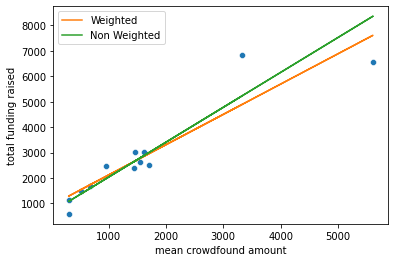

In [17]:
sns.scatterplot(x="crowdfund_amount_contributions_usd", y = "total",  legend=False, data=data_ag, sizes=(40, 400))
plt.plot(data_ag["crowdfund_amount_contributions_usd"], model1.predict(data_ag["crowdfund_amount_contributions_usd"]), c="C1", label = "Weighted")
plt.plot(data_ag["crowdfund_amount_contributions_usd"], model2.predict(data_ag["crowdfund_amount_contributions_usd"]), c="C2", label = "Non Weighted")
plt.xlabel("mean crowdfound amount")
plt.ylabel("total funding raised")
plt.legend();

In [18]:
model1 = smf.wls('total ~ crowdfund_amount_contributions_usd + num_unique_contributors', data=data_ag, weights=data_ag["grant_id"]).fit()
model1.summary().tables[1]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,181.9029,494.201,0.368,0.721,-936.057,1299.863
crowdfund_amount_contributions_usd,1.2796,0.185,6.901,0.000,0.860,1.699
num_unique_contributors,2.9492,1.611,1.831,0.100,-0.695,6.593


In [19]:
data.region.value_counts()

europe            12
none              12
north_america     12
oceania           12
undefined         12
latin_america     11
africa             9
east_asia          9
middle_east        8
india              7
southeast_asia     7
Name: region, dtype: int64

In [20]:
model2 = smf.wls('total ~ C(region) + crowdfund_amount_contributions_usd + round_number', data=data, weights=data["grant_id"]).fit()
model2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1266.1273,868.237,-1.458,0.148,-2989.115,456.860
C(region)[T.east_asia],434.0940,833.890,0.521,0.604,-1220.733,2088.921
C(region)[T.europe],748.3015,756.625,0.989,0.325,-753.196,2249.799
C(region)[T.india],-86.9118,1027.990,-0.085,0.933,-2126.924,1953.100
C(region)[T.latin_america],567.6049,866.701,0.655,0.514,-1152.335,2287.545
C(region)[T.middle_east],-467.5637,1106.128,-0.423,0.673,-2662.638,1727.511
C(region)[T.none],545.3167,750.187,0.727,0.469,-943.404,2034.038
C(region)[T.north_america],1027.4922,760.131,1.352,0.180,-480.962,2535.946
C(region)[T.oceania],1351.7243,1282.019,1.054,0.294,-1192.401,3895.849
C(region)[T.southeast_asia],699.2837,1047.442,0.668,0.506,-1379.330,2777.898


In [21]:
features = ["total","crowdfund_amount_contributions_usd"]
#features = ["total"]
inverted = (data.query("round_number < 11 and round_number > 5") # filter pre-intervention period
            .pivot(index='region', columns="round_number")[features] # make one column per year and one row per state
            .T # flip the table to have one column per region
            .fillna(0)) 

inverted.head()

region                   africa    east_asia       europe        india  \
      round_number                                                       
total 6             1024.750000   163.700000   418.541613    37.580000   
      7              398.705000   441.648571  3519.742727  4752.887500   
      8             2440.992500  2815.130667  4688.532609   600.282500   
      9              493.239333  2461.653220  2809.642973   718.680000   
      10            1012.313846  1629.730597  1836.841472   557.821923   

region              latin_america  middle_east         none  north_america  \
      round_number                                                           
total 6                582.617500     8.921111   514.749640    1190.898214   
      7               1421.448333    56.680000  2054.723840    3873.238485   
      8               1809.586667  1818.308000  2679.742879   14213.945600   
      9               1776.559118   347.390476  1742.857869    2451.042079   
      10              3197.531538   559.175000  1421.295238    2537.179031   

region                  oceania  southeast_asia    undefined  
      round_number                                            
total 6             1628.193333        0.000000  1019.658125  
      7             1237.122500     8743.790000  2420.801406  
      8             6775.385000     4140.744000  8317.960789  
      9             2366.032500     2288.674000  4067.902128  
      10            5627.314545     3521.501034  4010.095155

In [22]:
y = inverted['africa'].values # state of california
X = inverted.drop(columns=['africa']).values  # other states

from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.132,  2.172,  0.314,  0.078, -1.795, -1.515,  0.255,  0.935,
       -0.625, -0.932])

In [23]:
calif_synth_lr = (data.query("region!='africa' and round_number > 5")
                  .pivot(index='round_number', columns="region")["total"]
                  .values.dot(weights_lr))

In [24]:
calif_synth_lr

array([1024.75      ,  398.705     , 2440.9925    ,  493.23933333,
       1012.31384615, 2705.12679626, 3897.86785757])

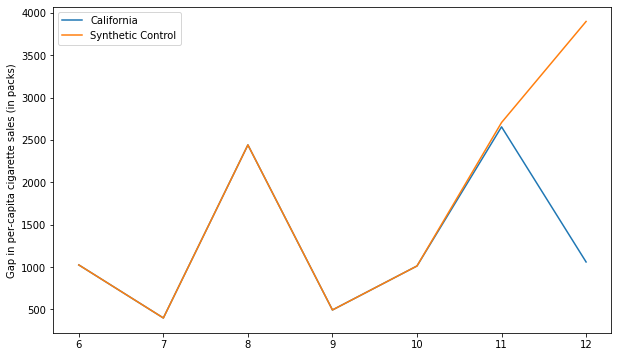

In [25]:
plt.figure(figsize=(10,6))
plt.plot(data.query("region=='africa'and round_number > 5")["round_number"], data.query("region=='africa'and round_number > 5")["total"], label="California")
plt.plot(data.query("region=='africa'and round_number > 5")["round_number"], calif_synth_lr, label="Synthetic Control")
#plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

In [26]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [27]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [28]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000231261


array([0.    , 0.    , 0.0216, 0.    , 0.8275, 0.0239, 0.017 , 0.1099,
       0.    , 0.    ])

In [29]:
calif_synth = (data.query("region!='africa' and round_number > 5")
                  .pivot(index='round_number', columns="region")["total"]
                  .values.dot(calif_weights))

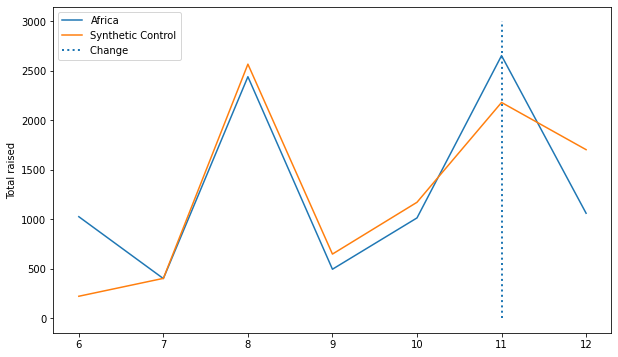

In [30]:
plt.figure(figsize=(10,6))
plt.plot(data.query("region=='africa'and round_number > 5")["round_number"], data.query("region=='africa'and round_number > 5")["total"], label="Africa")
plt.plot(data.query("region=='africa'and round_number > 5")["round_number"], calif_synth, label="Synthetic Control")
plt.vlines(x=11, ymin=0, ymax=3000, linestyle=":", lw=2, label="Change ")
plt.ylabel("Total raised")
plt.legend();

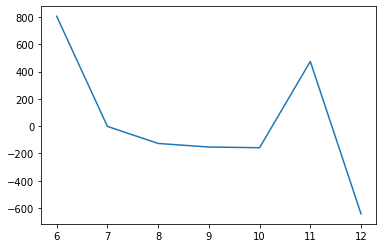

In [31]:
plt.plot(data.query("region=='africa'and round_number > 5")["round_number"], data.query("region=='africa'and round_number > 5")["total"] - calif_synth,
         label=" Effect")